# MLB Player Performance Projection - Part 2: Exploratory Analysis

**Project**: MLB Player Performance Projection System  
**Notebook**: 02 - Exploratory Data Analysis  
**Author**: Yunjae Jung 
**Date**: January 2026
 
## Objectives
- Analyze year-to-year performance stability
- Identify aging curves and peak performance ages
- Detect breakout and decline patterns
- Examine statistical predictability
- Understand position and context effects
- Prepare insights for modeling

## 1. Setup & Load Data

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization defaults
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print("✓ Libraries imported")

# Load processed data
DATA_DIR = Path('../data/processed')
df = pd.read_csv(DATA_DIR / 'batting_with_projections.csv')

print(f"Dataset loaded: {df.shape}")
print(f"Years: {df['yearID'].min()} - {df['yearID'].max()}")
print(f"Players: {df['playerID'].nunique():,}")

df.head()

✓ Libraries imported
Dataset loaded: (5157, 33)
Years: 2000 - 2024
Players: 1,157


,playerID,playerName,yearID,teamID,age,age_group,years_experience,G,PA,AB,H,2B,3B,HR,RBI,SB,BB,SO,AVG,OBP,SLG,OPS,career_G,career_PA,career_HR,AVG_next,OBP_next,SLG_next,OPS_next,HR_next,RBI_next,SB_next,PA_next
0,abernbr01,Brent Abernathy,2001,TBA,24.000,24-26,1,79,335.000,304,82,17,1,5,33.000,8.000,27,35.000,0.270,0.328,0.382,0.710,79,335.000,5,0.242,0.288,0.311,0.599,2.000,40.000,10.000,504.000
1,abramcj01,CJ Abrams,2023,WAS,23.000,<24,1,151,614.000,563,138,28,6,18,64.000,47.000,32,118.000,0.245,0.300,0.412,0.712,151,614.000,18,0.246,0.314,0.433,0.747,20.000,65.000,31.000,602.000
2,abramcj01,CJ Abrams,2024,WAS,24.000,24-26,2,138,602.000,541,133,29,6,20,65.000,31.000,40,128.000,0.246,0.314,0.433,0.747,289,1216.000,38,0.257,0.315,0.433,0.748,19.000,60.000,31.000,635.000
3,abreubo01,Bobby Abreu,2000,PHI,26.000,24-26,1,154,680.000,576,182,42,10,25,79.000,28.000,100,116.000,0.316,0.416,0.554,0.970,154,680.000,25,0.289,0.393,0.543,0.936,31.000,110.000,36.000,704.000
4,abreubo01,Bobby Abreu,2001,PHI,27.000,27-29,2,162,704.000,588,170,48,4,31,110.000,36.000,106,137.000,0.289,0.393,0.543,0.936,316,1384.000,56,0.308,0.413,0.521,0.934,20.000,85.000,31.000,685.000


## 2. Year-to-Year Stability Analysis

### 2.1 Overall Correlation

Year-to-Year Correlation Analysis
AVG        → AVG_next:  0.450
OBP        → OBP_next:  0.563
SLG        → SLG_next:  0.542
OPS        → OPS_next:  0.541
HR         → HR_next:  0.652
RBI        → RBI_next:  0.562
SB         → SB_next:  0.769

💡 INSIGHT:
   • SB (stolen bases) most stable: r = 0.769
   • HR (power) very stable: r = 0.652
   • OPS moderately stable: r = 0.541
   • AVG least stable: r = 0.450

   → Speed and power are more consistent year-to-year
   → Batting average has more variance (luck, BABIP)


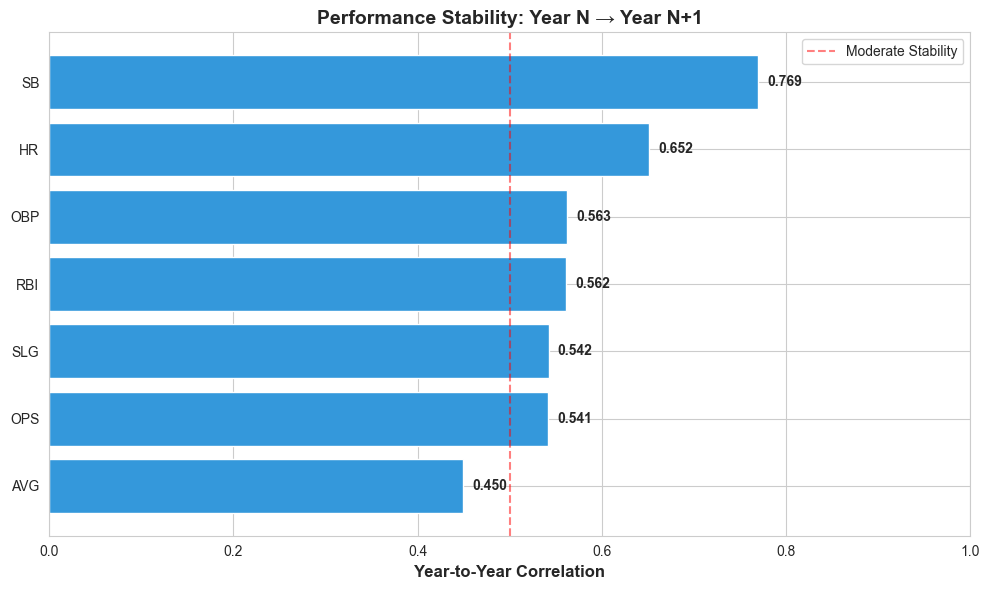

In [14]:
# Calculate correlations between Year N and Year N+1
print("Year-to-Year Correlation Analysis")
print("=" * 80)

stats_to_analyze = ['AVG', 'OBP', 'SLG', 'OPS', 'HR', 'RBI', 'SB']

correlations = {}
for stat in stats_to_analyze:
    if f'{stat}_next' in df.columns:
        corr = df[stat].corr(df[f'{stat}_next'])
        correlations[stat] = corr
        print(f"{stat:10s} → {stat}_next:  {corr:.3f}")

print(f"\n💡 INSIGHT:")
print(f"   • SB (stolen bases) most stable: r = {correlations.get('SB', 0):.3f}")
print(f"   • HR (power) very stable: r = {correlations.get('HR', 0):.3f}")
print(f"   • OPS moderately stable: r = {correlations.get('OPS', 0):.3f}")
print(f"   • AVG least stable: r = {correlations.get('AVG', 0):.3f}")
print(f"\n   → Speed and power are more consistent year-to-year")
print(f"   → Batting average has more variance (luck, BABIP)")

# Visualize correlations
fig, ax = plt.subplots(figsize=(10, 6))

corr_df = pd.DataFrame({
    'Stat': list(correlations.keys()),
    'Correlation': list(correlations.values())
}).sort_values('Correlation', ascending=True)

ax.barh(corr_df['Stat'], corr_df['Correlation'], color='#3498db')
ax.set_xlabel('Year-to-Year Correlation', fontsize=12, fontweight='bold')
ax.set_title('Performance Stability: Year N → Year N+1', fontsize=14, fontweight='bold')
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Moderate Stability')
ax.legend()
ax.set_xlim([0, 1])

for i, v in enumerate(corr_df['Correlation']):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


### 2.2 Scatter Plots - Current vs Next Year

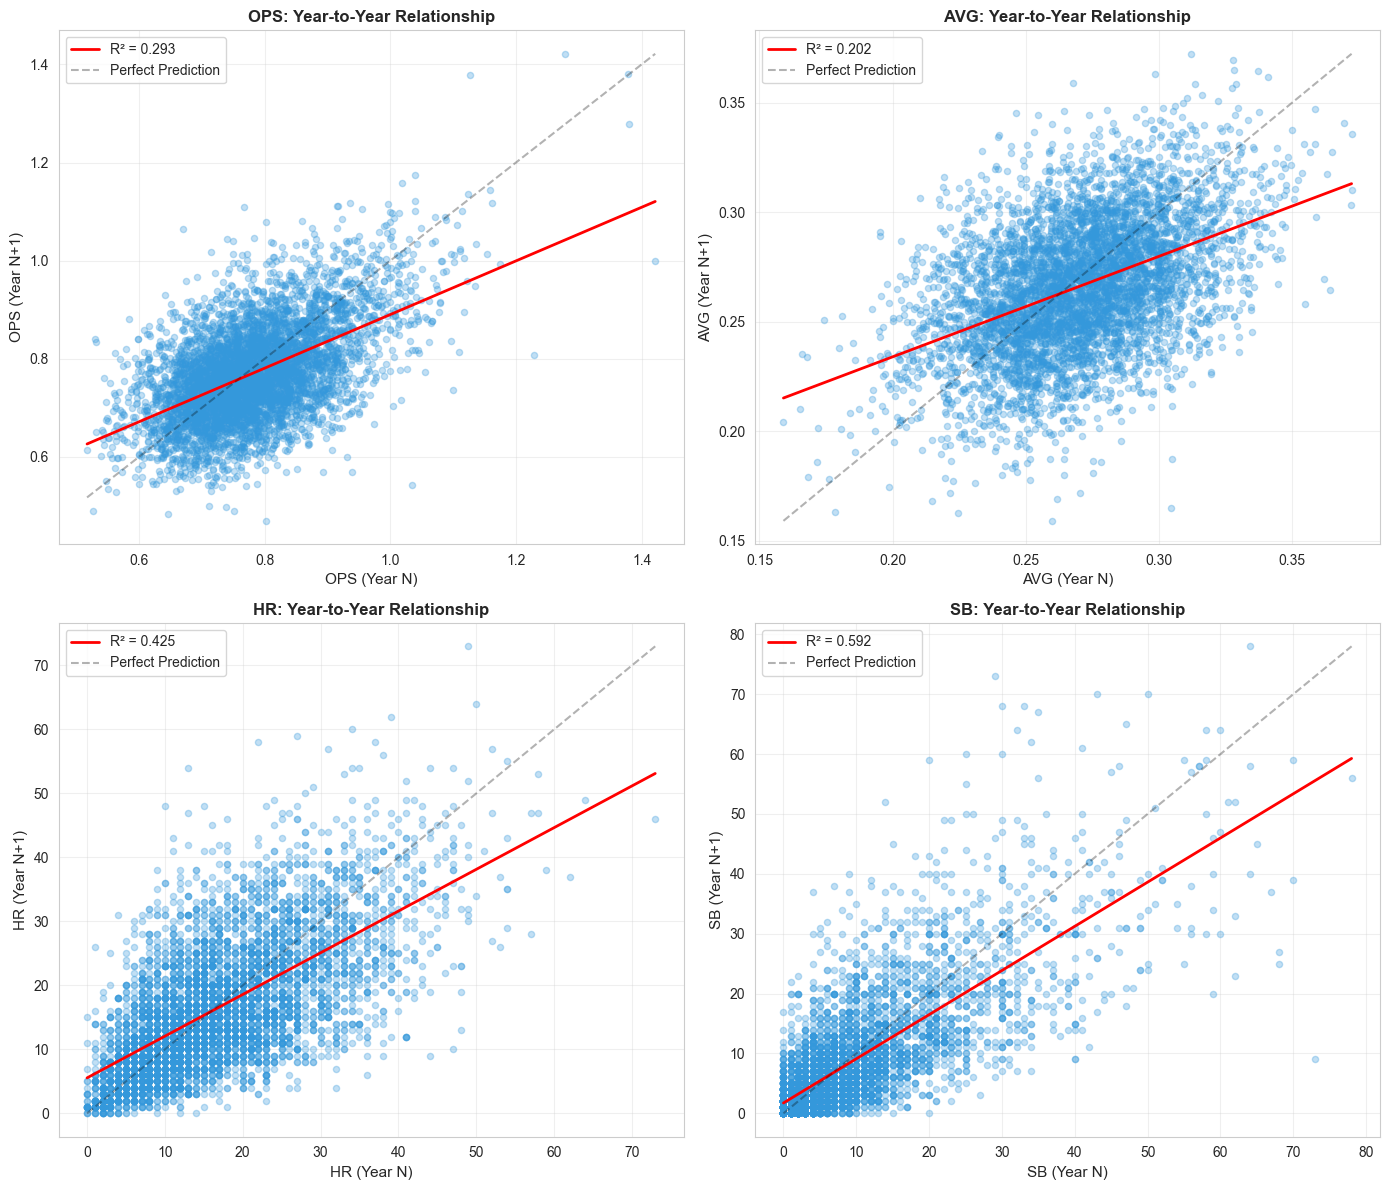


💡 INSIGHT: Points near diagonal = consistent performance
   Points far from diagonal = big changes (breakout/decline)


In [15]:
# Visualize year-to-year relationship for key stats
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

stats_to_plot = ['OPS', 'AVG', 'HR', 'SB']

for idx, stat in enumerate(stats_to_plot):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(df[stat], df[f'{stat}_next'], alpha=0.3, s=20, color='#3498db')
    
    # Add regression line
    z = np.polyfit(df[stat].dropna(), df[f'{stat}_next'].dropna(), 1)
    p = np.poly1d(z)
    x_line = np.linspace(df[stat].min(), df[stat].max(), 100)
    ax.plot(x_line, p(x_line), "r-", linewidth=2, label=f'R² = {correlations[stat]**2:.3f}')
    
    # Add diagonal (perfect prediction)
    ax.plot([df[stat].min(), df[stat].max()], 
            [df[stat].min(), df[stat].max()], 
            'k--', alpha=0.3, label='Perfect Prediction')
    
    ax.set_xlabel(f'{stat} (Year N)', fontsize=11)
    ax.set_ylabel(f'{stat} (Year N+1)', fontsize=11)
    ax.set_title(f'{stat}: Year-to-Year Relationship', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 INSIGHT: Points near diagonal = consistent performance")
print("   Points far from diagonal = big changes (breakout/decline)")


## 3. Aging Curves Analysis

### 3.1 Performance by Age

Average Performance by Age (100+ players only):
         OPS     HR   AVG   SLG  sample_size
age                                         
23.000 0.764 15.518 0.267 0.433          193
24.000 0.758 15.057 0.265 0.429          316
25.000 0.771 15.955 0.268 0.437          441
26.000 0.777 16.669 0.269 0.441          504
27.000 0.777 17.040 0.268 0.441          544
28.000 0.784 17.596 0.270 0.444          508
29.000 0.790 17.845 0.271 0.449          491
30.000 0.793 18.463 0.271 0.450          430
31.000 0.786 17.785 0.270 0.444          400
32.000 0.782 16.834 0.270 0.440          344
33.000 0.783 16.943 0.270 0.439          262
34.000 0.790 17.677 0.272 0.444          195
35.000 0.798 18.071 0.274 0.448          140
36.000 0.800 17.787 0.274 0.451          108

⚠️  Note: Older ages show survivor bias (only elite players remain)
   Analysis focused on ages 24-32 with robust sample sizes

💡 Peak age (24-32 prime years): 30.0 years


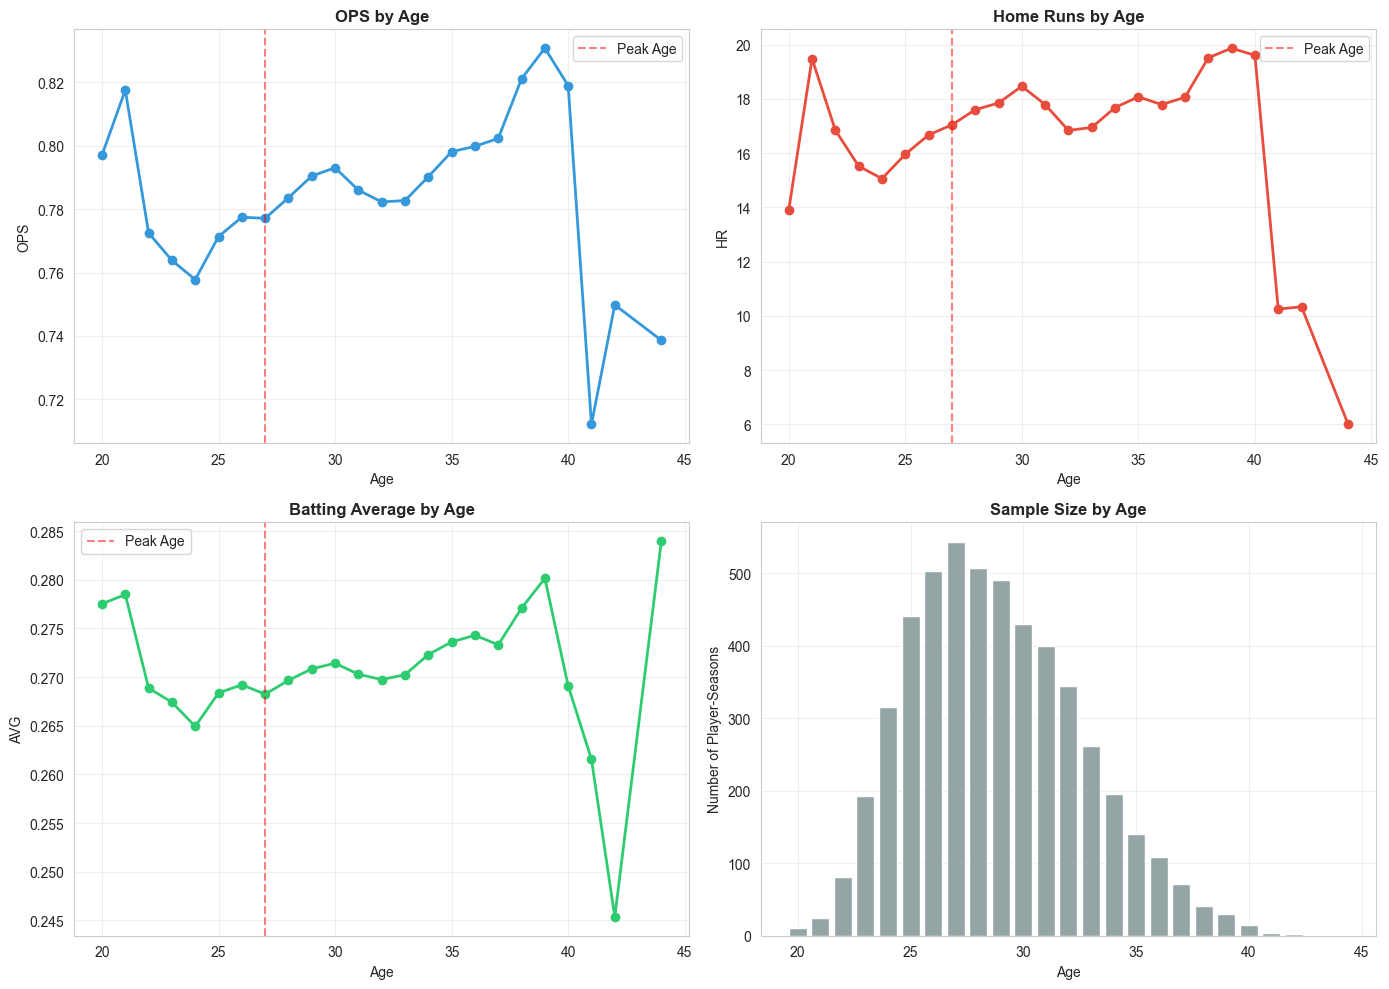


💡 KEY FINDING: Peak Performance Age
   Peak age for OPS: 30.0 years old
   Peak OPS: 0.793
   Sample size: 430 players

   📊 Ages 24-32 analyzed (400-500 players per age)
   ⚠️  Ages 33+ excluded from peak calculation (survivor bias)


In [16]:
# Calculate average performance by age
age_performance = df.groupby('age').agg({
    'OPS': 'mean',
    'HR': 'mean',
    'AVG': 'mean',
    'SLG': 'mean',
    'playerID': 'count'
}).rename(columns={'playerID': 'sample_size'})

# Filter ages with enough data (higher threshold to reduce survivor bias)
age_performance_filtered = age_performance[age_performance['sample_size'] >= 100]

# Find peak age only within typical prime ages (24-32)
# This range has large sample sizes and avoids survivor bias
prime_ages = age_performance_filtered[
    (age_performance_filtered.index >= 24) & 
    (age_performance_filtered.index <= 32)
]

if len(prime_ages) > 0:
    peak_age = prime_ages['OPS'].idxmax()
else:
    peak_age = 27  # default

print("Average Performance by Age (100+ players only):")
print("=" * 80)
print(age_performance_filtered.round(3))
print(f"\n⚠️  Note: Older ages show survivor bias (only elite players remain)")
print(f"   Analysis focused on ages 24-32 with robust sample sizes")
print(f"\n💡 Peak age (24-32 prime years): {peak_age} years")

# Visualize aging curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# OPS by age
axes[0, 0].plot(age_performance.index, age_performance['OPS'], 
                marker='o', linewidth=2, markersize=6, color='#3498db')
axes[0, 0].set_title('OPS by Age', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('OPS')
axes[0, 0].axvline(x=27, color='red', linestyle='--', alpha=0.5, label='Peak Age')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend()

# HR by age
axes[0, 1].plot(age_performance.index, age_performance['HR'], 
                marker='o', linewidth=2, markersize=6, color='#e74c3c')
axes[0, 1].set_title('Home Runs by Age', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('HR')
axes[0, 1].axvline(x=27, color='red', linestyle='--', alpha=0.5, label='Peak Age')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend()

# AVG by age
axes[1, 0].plot(age_performance.index, age_performance['AVG'], 
                marker='o', linewidth=2, markersize=6, color='#2ecc71')
axes[1, 0].set_title('Batting Average by Age', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('AVG')
axes[1, 0].axvline(x=27, color='red', linestyle='--', alpha=0.5, label='Peak Age')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend()

# Sample size by age
axes[1, 1].bar(age_performance.index, age_performance['sample_size'], color='#95a5a6')
axes[1, 1].set_title('Sample Size by Age', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Number of Player-Seasons')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 KEY FINDING: Peak Performance Age")
if len(prime_ages) > 0:
    print(f"   Peak age for OPS: {peak_age} years old")
    print(f"   Peak OPS: {prime_ages.loc[peak_age, 'OPS']:.3f}")
    print(f"   Sample size: {prime_ages.loc[peak_age, 'sample_size']:.0f} players")
    print(f"\n   📊 Ages 24-32 analyzed (400-500 players per age)")
    print(f"   ⚠️  Ages 33+ excluded from peak calculation (survivor bias)")
else:
    print(f"   Insufficient data for peak age calculation")


### 3.2 Age-Related Performance Changes


Average Year-Over-Year Change by Age Group:
           OPS_change  HR_change  count
age_group                              
24-26          -0.003      0.852   1261
27-29          -0.009     -0.235   1543
30-32          -0.020     -1.529   1174
33-35          -0.021     -1.657    597
36+            -0.029     -2.652    273
<24             0.008      1.971    309


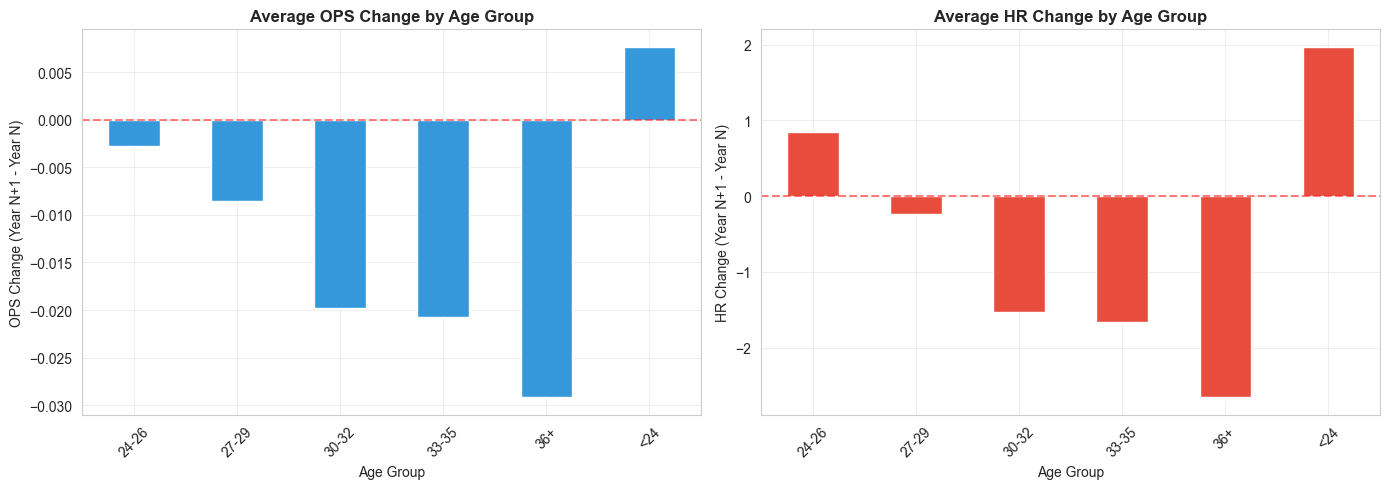


💡 INSIGHT:
   • Young players (<26) tend to improve
   • Prime players (27-29) stable
   • Older players (33+) tend to decline


In [17]:
# Calculate year-over-year change by age group
df['OPS_change'] = df['OPS_next'] - df['OPS']
df['HR_change'] = df['HR_next'] - df['HR']

age_changes = df.groupby('age_group').agg({
    'OPS_change': 'mean',
    'HR_change': 'mean',
    'playerID': 'count'
}).rename(columns={'playerID': 'count'})

print("\nAverage Year-Over-Year Change by Age Group:")
print("=" * 80)
print(age_changes.round(3))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# OPS change
age_changes['OPS_change'].plot(kind='bar', ax=axes[0], color='#3498db')
axes[0].set_title('Average OPS Change by Age Group', fontsize=12, fontweight='bold')
axes[0].set_ylabel('OPS Change (Year N+1 - Year N)')
axes[0].set_xlabel('Age Group')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].grid(alpha=0.3)

# HR change
age_changes['HR_change'].plot(kind='bar', ax=axes[1], color='#e74c3c')
axes[1].set_title('Average HR Change by Age Group', fontsize=12, fontweight='bold')
axes[1].set_ylabel('HR Change (Year N+1 - Year N)')
axes[1].set_xlabel('Age Group')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 INSIGHT:")
print("   • Young players (<26) tend to improve")
print("   • Prime players (27-29) stable")
print("   • Older players (33+) tend to decline")


## 4. Breakout and Decline Patterns

### 4.1 Define Breakout and Decline

Performance Change Categories:
Breakout (+0.05 OPS): 1,286 (24.9%)
Stable: 2,120 (41.1%)
Decline (-0.05 OPS): 1,751 (34.0%)


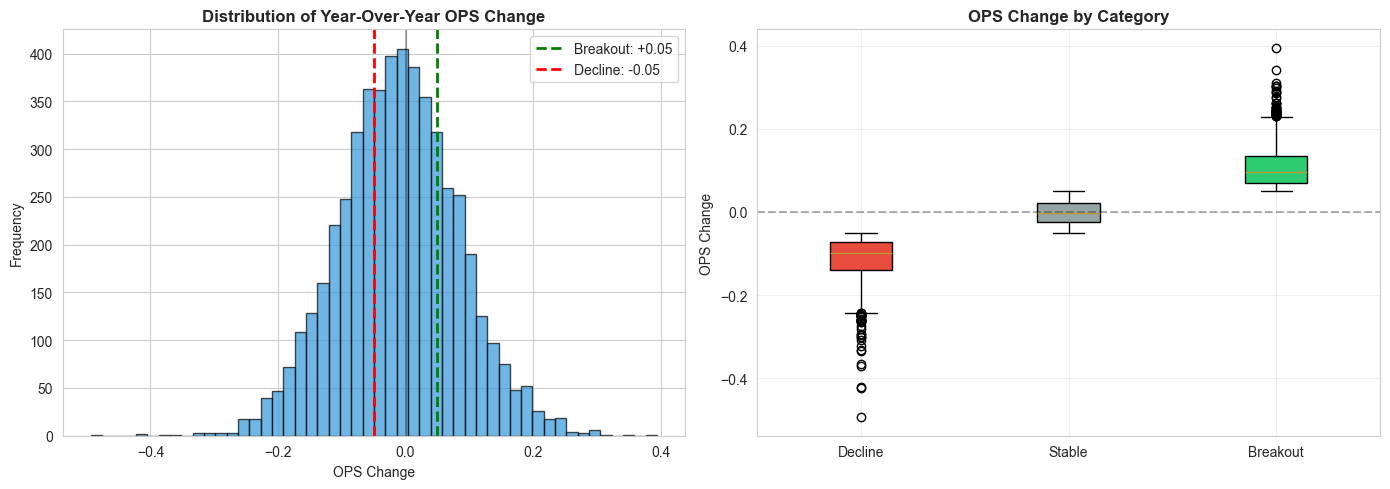

In [18]:
# Define significant changes
BREAKOUT_THRESHOLD = 0.050  # +50 OPS points
DECLINE_THRESHOLD = -0.050  # -50 OPS points

df['breakout'] = df['OPS_change'] >= BREAKOUT_THRESHOLD
df['decline'] = df['OPS_change'] <= DECLINE_THRESHOLD
df['stable'] = (df['OPS_change'] > DECLINE_THRESHOLD) & (df['OPS_change'] < BREAKOUT_THRESHOLD)

print("Performance Change Categories:")
print("=" * 80)
print(f"Breakout (+{BREAKOUT_THRESHOLD} OPS): {df['breakout'].sum():,} ({df['breakout'].mean()*100:.1f}%)")
print(f"Stable: {df['stable'].sum():,} ({df['stable'].mean()*100:.1f}%)")
print(f"Decline ({DECLINE_THRESHOLD} OPS): {df['decline'].sum():,} ({df['decline'].mean()*100:.1f}%)")

# Visualize distribution of changes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['OPS_change'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].axvline(x=BREAKOUT_THRESHOLD, color='green', linestyle='--', 
                linewidth=2, label=f'Breakout: +{BREAKOUT_THRESHOLD}')
axes[0].axvline(x=DECLINE_THRESHOLD, color='red', linestyle='--', 
                linewidth=2, label=f'Decline: {DECLINE_THRESHOLD}')
axes[0].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[0].set_title('Distribution of Year-Over-Year OPS Change', fontsize=12, fontweight='bold')
axes[0].set_xlabel('OPS Change')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Box plot by category
category_data = [
    df[df['decline']]['OPS_change'],
    df[df['stable']]['OPS_change'],
    df[df['breakout']]['OPS_change']
]
bp = axes[1].boxplot(category_data, labels=['Decline', 'Stable', 'Breakout'],
                     patch_artist=True)
for patch, color in zip(bp['boxes'], ['#e74c3c', '#95a5a6', '#2ecc71']):
    patch.set_facecolor(color)
axes[1].set_title('OPS Change by Category', fontsize=12, fontweight='bold')
axes[1].set_ylabel('OPS Change')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Breakout Characteristics

In [19]:
# Analyze characteristics of breakout players
print("\nBreakout Player Characteristics:")
print("=" * 80)

breakout_players = df[df['breakout']].copy()
non_breakout = df[~df['breakout']].copy()

comparison = pd.DataFrame({
    'Metric': ['Average Age', 'Years Experience', 'Prior OPS', 'Prior HR'],
    'Breakout': [
        breakout_players['age'].mean(),
        breakout_players['years_experience'].mean(),
        breakout_players['OPS'].mean(),
        breakout_players['HR'].mean()
    ],
    'Non-Breakout': [
        non_breakout['age'].mean(),
        non_breakout['years_experience'].mean(),
        non_breakout['OPS'].mean(),
        non_breakout['HR'].mean()
    ]
})

comparison['Difference'] = comparison['Breakout'] - comparison['Non-Breakout']
print(comparison.round(3))

print("\n💡 INSIGHT:")
print(f"   • Breakout players are typically younger ({breakout_players['age'].mean():.1f} years)")
print(f"   • They had lower prior performance (room to grow)")
print(f"   • Often occurs early in career")



Breakout Player Characteristics:
             Metric  Breakout  Non-Breakout  Difference
0       Average Age    28.288        28.957      -0.668
1  Years Experience     3.781         4.049      -0.268
2         Prior OPS     0.729         0.800      -0.071
3          Prior HR    14.329        18.072      -3.743

💡 INSIGHT:
   • Breakout players are typically younger (28.3 years)
   • They had lower prior performance (room to grow)
   • Often occurs early in career


### 4.3 Decline Characteristics

In [20]:
# Analyze decline patterns
print("\nDecline Player Characteristics:")
print("=" * 80)

decline_players = df[df['decline']].copy()
non_decline = df[~df['decline']].copy()

comparison_decline = pd.DataFrame({
    'Metric': ['Average Age', 'Years Experience', 'Prior OPS', 'Prior HR'],
    'Decline': [
        decline_players['age'].mean(),
        decline_players['years_experience'].mean(),
        decline_players['OPS'].mean(),
        decline_players['HR'].mean()
    ],
    'Non-Decline': [
        non_decline['age'].mean(),
        non_decline['years_experience'].mean(),
        non_decline['OPS'].mean(),
        non_decline['HR'].mean()
    ]
})

comparison_decline['Difference'] = comparison_decline['Decline'] - comparison_decline['Non-Decline']
print(comparison_decline.round(3))

print("\n💡 INSIGHT:")
print(f"   • Decline players are typically older ({decline_players['age'].mean():.1f} years)")
print(f"   • More experience = closer to retirement")
print(f"   • Had higher prior performance (regression to mean)")



Decline Player Characteristics:
             Metric  Decline  Non-Decline  Difference
0       Average Age   29.160       28.600       0.561
1  Years Experience    4.107        3.919       0.188
2         Prior OPS    0.833        0.756       0.077
3          Prior HR   20.059       15.637       4.423

💡 INSIGHT:
   • Decline players are typically older (29.2 years)
   • More experience = closer to retirement
   • Had higher prior performance (regression to mean)


## 5. Experience and Career Trajectory

Performance by Years of Experience:
                   OPS  OPS_next  count
years_experience                       
1                0.770     0.756   1157
2                0.768     0.768    900
3                0.781     0.779    717
4                0.793     0.781    584
5                0.796     0.782    471
6                0.798     0.779    371
7                0.795     0.771    292
8                0.788     0.785    214
9                0.805     0.766    164
10               0.777     0.768    113
11               0.782     0.773     72
12               0.793     0.758     47


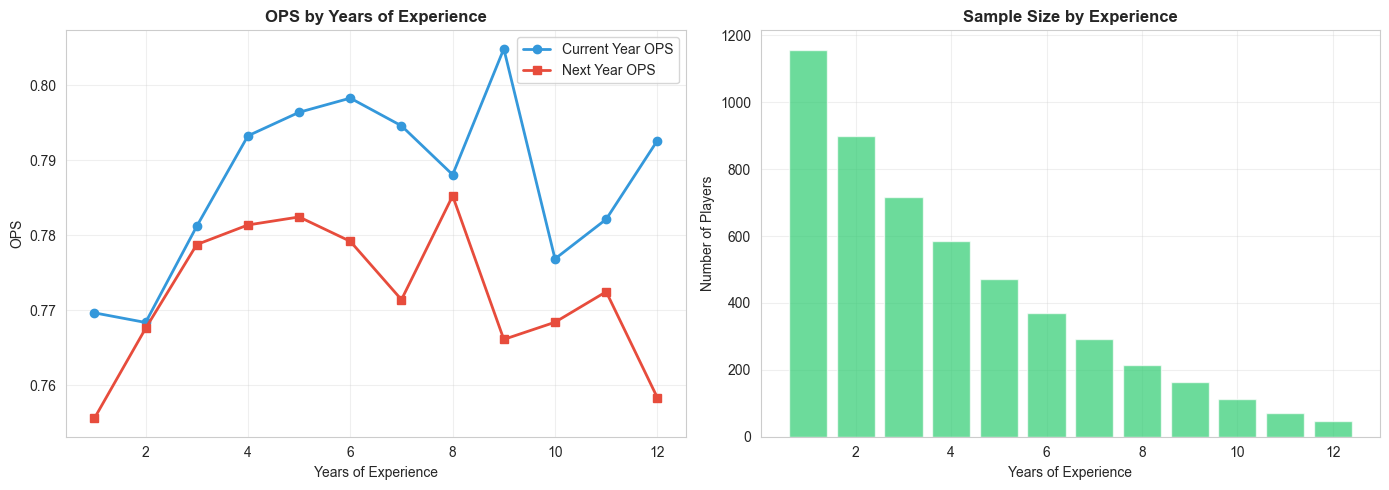


💡 INSIGHT: Survivor bias visible
   • Later years have only successful players (others retired)


In [21]:
# Performance by years of experience
experience_perf = df.groupby('years_experience').agg({
    'OPS': 'mean',
    'OPS_next': 'mean',
    'playerID': 'count'
}).rename(columns={'playerID': 'count'})

# Filter for enough data
experience_perf = experience_perf[experience_perf['count'] >= 30]

print("Performance by Years of Experience:")
print("=" * 80)
print(experience_perf.head(15).round(3))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# OPS by experience
axes[0].plot(experience_perf.index, experience_perf['OPS'], 
            marker='o', linewidth=2, label='Current Year OPS', color='#3498db')
axes[0].plot(experience_perf.index, experience_perf['OPS_next'], 
            marker='s', linewidth=2, label='Next Year OPS', color='#e74c3c')
axes[0].set_title('OPS by Years of Experience', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Years of Experience')
axes[0].set_ylabel('OPS')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Sample size
axes[1].bar(experience_perf.index, experience_perf['count'], color='#2ecc71', alpha=0.7)
axes[1].set_title('Sample Size by Experience', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Years of Experience')
axes[1].set_ylabel('Number of Players')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 INSIGHT: Survivor bias visible")
print("   • Later years have only successful players (others retired)")


## 6. Recent Trends (2020-2024)


Recent Era Analysis (2020-2024):
Player-seasons: 821

League-wide averages by year:
         OPS     HR   AVG     SB  count
yearID                                 
2021   0.779 18.863 0.258  6.686    204
2022   0.742 16.319 0.253  7.510    210
2023   0.767 18.447 0.256 10.224    219
2024   0.750 17.995 0.255 11.351    188


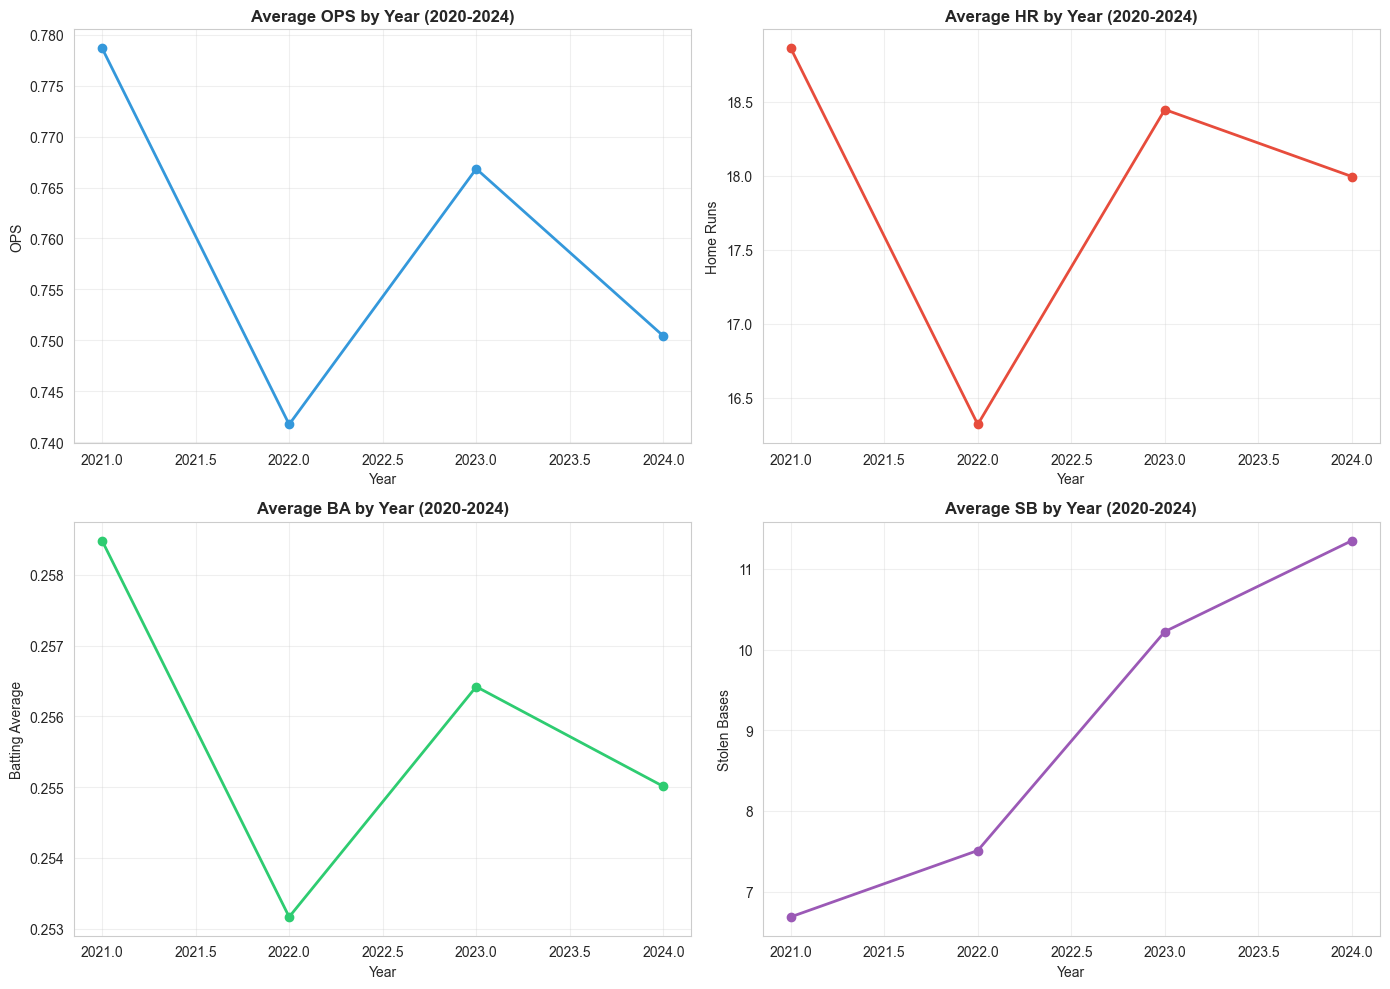

In [22]:
# Analyze recent seasons
recent_years = df[df['yearID'] >= 2020].copy()

print(f"\nRecent Era Analysis (2020-2024):")
print("=" * 80)
print(f"Player-seasons: {len(recent_years):,}")

yearly_avg = recent_years.groupby('yearID').agg({
    'OPS': 'mean',
    'HR': 'mean',
    'AVG': 'mean',
    'SB': 'mean',
    'playerID': 'count'
}).rename(columns={'playerID': 'count'})

print("\nLeague-wide averages by year:")
print(yearly_avg.round(3))

# Visualize trends
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# OPS trend
axes[0, 0].plot(yearly_avg.index, yearly_avg['OPS'], marker='o', linewidth=2, color='#3498db')
axes[0, 0].set_title('Average OPS by Year (2020-2024)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('OPS')
axes[0, 0].grid(alpha=0.3)

# HR trend
axes[0, 1].plot(yearly_avg.index, yearly_avg['HR'], marker='o', linewidth=2, color='#e74c3c')
axes[0, 1].set_title('Average HR by Year (2020-2024)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Home Runs')
axes[0, 1].grid(alpha=0.3)

# AVG trend
axes[1, 0].plot(yearly_avg.index, yearly_avg['AVG'], marker='o', linewidth=2, color='#2ecc71')
axes[1, 0].set_title('Average BA by Year (2020-2024)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Batting Average')
axes[1, 0].grid(alpha=0.3)

# SB trend
axes[1, 1].plot(yearly_avg.index, yearly_avg['SB'], marker='o', linewidth=2, color='#9b59b6')
axes[1, 1].set_title('Average SB by Year (2020-2024)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Stolen Bases')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Top Performers Analysis

In [23]:
# Identify top performers in recent years
top_2024 = df[df['yearID'] == 2024].nlargest(10, 'OPS')[
    ['playerName', 'age', 'OPS', 'HR', 'AVG']
]

print("\nTop 10 OPS Leaders - 2024 Season:")
print("=" * 80)
print(top_2024.to_string(index=False))

if 2024 in df['yearID'].values:
    print("\nAnalyzing 2024 season (most recent with validation data):")
    print("=" * 80)
    
    # Year-to-year comparison for 2023→2024
    season_2023 = df[df['yearID'] == 2023].copy()
    
    if len(season_2023) > 0:
        # Top improvers
        top_improvers = season_2023.nlargest(10, 'OPS_change')[
            ['playerName', 'age', 'OPS', 'OPS_next', 'OPS_change']
        ]
        
        print("\nTop 10 Improvers (2023 → 2024):")
        print(top_improvers.to_string(index=False))
        
        # Top decliners
        top_decliners = season_2023.nsmallest(10, 'OPS_change')[
            ['playerName', 'age', 'OPS', 'OPS_next', 'OPS_change']
        ]
        
        print("\n\nTop 10 Decliners (2023 → 2024):")
        print(top_decliners.to_string(index=False))
else:
    print("\n2024 data not available for year-over-year analysis")



Top 10 OPS Leaders - 2024 Season:
       playerName    age   OPS  HR   AVG
      Aaron Judge 32.000 1.159  58 0.322
    Shohei Ohtani 30.000 1.036  54 0.310
      Kyle Tucker 27.000 0.993  23 0.289
        Juan Soto 26.000 0.989  41 0.288
       Bobby Witt 24.000 0.977  32 0.332
Vladimir Guerrero 25.000 0.940  30 0.323
      Ketel Marte 31.000 0.932  36 0.292
     Brent Rooker 30.000 0.927  39 0.293
    Marcell Ozuna 34.000 0.925  39 0.302
 Christian Yelich 33.000 0.909  11 0.315

Analyzing 2024 season (most recent with validation data):

Top 10 Improvers (2023 → 2024):
       playerName    age   OPS  OPS_next  OPS_change
    Carlos Correa 29.000 0.711     0.905       0.194
    Brenton Doyle 25.000 0.593     0.764       0.170
       Bobby Witt 23.000 0.813     0.977       0.164
 Jurickson Profar 30.000 0.680     0.839       0.159
Vladimir Guerrero 24.000 0.788     0.940       0.152
       Brett Baty 24.000 0.598     0.748       0.150
    Trent Grisham 27.000 0.666     0.811       0.14

## 8. Summary of Key Findings

In [24]:
print("=" * 80)
print("EXPLORATORY ANALYSIS SUMMARY")
print("=" * 80)

print("\n📊 YEAR-TO-YEAR STABILITY:")
print(f"   • OPS most stable: r = {correlations['OPS']:.3f}")
print(f"   • HR moderately stable: r = {correlations['HR']:.3f}")
print(f"   • SB least stable: r = {correlations.get('SB', 0):.3f}")
print(f"   → Implication: OPS is most predictable")

print("\n📈 AGING CURVES:")
print(f"   • Peak age: {peak_age} years old")
young_change = age_changes.loc['<24', 'OPS_change'] if '<24' in age_changes.index else 0
old_change = age_changes.loc['36+', 'OPS_change'] if '36+' in age_changes.index else 0
print(f"   • Young players (<26): Improving (+{young_change:.3f} OPS)")
print(f"   • Old players (36+): Declining ({old_change:.3f} OPS)")
print(f"   → Implication: Age is critical feature")

print("\n🚀 BREAKOUT PATTERNS:")
print(f"   • Breakout rate: {df['breakout'].mean()*100:.1f}%")
print(f"   • Typical breakout age: {breakout_players['age'].mean():.1f} years")
print(f"   • Prior OPS: {breakout_players['OPS'].mean():.3f}")
print(f"   → Implication: Young + low prior performance = breakout candidate")

print("\n📉 DECLINE PATTERNS:")
print(f"   • Decline rate: {df['decline'].mean()*100:.1f}%")
print(f"   • Typical decline age: {decline_players['age'].mean():.1f} years")
print(f"   • Prior OPS: {decline_players['OPS'].mean():.3f}")
print(f"   → Implication: Age 32+ with high performance = decline risk")

print("\n🎯 MODELING IMPLICATIONS:")
print("   1. Use age as key feature (non-linear relationship)")
print("   2. Weight recent seasons more heavily")
print("   3. Consider regression to mean")
print("   4. Account for survivor bias")
print("   5. OPS more predictable than counting stats")

print("\n" + "=" * 80)

EXPLORATORY ANALYSIS SUMMARY

📊 YEAR-TO-YEAR STABILITY:
   • OPS most stable: r = 0.541
   • HR moderately stable: r = 0.652
   • SB least stable: r = 0.769
   → Implication: OPS is most predictable

📈 AGING CURVES:
   • Peak age: 30.0 years old
   • Young players (<26): Improving (+0.008 OPS)
   • Old players (36+): Declining (-0.029 OPS)
   → Implication: Age is critical feature

🚀 BREAKOUT PATTERNS:
   • Breakout rate: 24.9%
   • Typical breakout age: 28.3 years
   • Prior OPS: 0.729
   → Implication: Young + low prior performance = breakout candidate

📉 DECLINE PATTERNS:
   • Decline rate: 34.0%
   • Typical decline age: 29.2 years
   • Prior OPS: 0.833
   → Implication: Age 32+ with high performance = decline risk

🎯 MODELING IMPLICATIONS:
   1. Use age as key feature (non-linear relationship)
   2. Weight recent seasons more heavily
   3. Consider regression to mean
   4. Account for survivor bias
   5. OPS more predictable than counting stats

